# 4. Human myocardial infarction atlas
Kuppe, C., Ramirez Flores, R. O., Li, Z., Hayat, S., Levinson, R. T., Liao, X., ... & Kramann, R. (2022). Spatial multi-omic map of human myocardial infarction. Nature, 608(7924), 766-777.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scanpro functions
from scanpro import scanpro
from scanpro.utils import convert_counts_to_df

In [2]:
# path where figures are going to be saved
FIG_PATH = 'plots'

------------------

## Read data

In [3]:
human_MI_counts = pd.read_csv("data/human_MI_counts.tsv", sep="\t")
human_MI = convert_counts_to_df(human_MI_counts, meta_cols=['Sample', 'Sex', 'Age', 'Patient_group', 'Zone'],
                                column_name="cell_type")

In [4]:
human_MI.head()

,Sample,Sex,Age,Patient_group,Zone,cell_type
cell_1,CK158,Female,44,Myogenic,Control,Adipocyte
cell_2,CK158,Female,44,Myogenic,Control,Adipocyte
cell_3,CK159,Female,63,Myogenic,Fibrotic,Adipocyte
cell_4,CK159,Female,63,Myogenic,Fibrotic,Adipocyte
cell_5,CK159,Female,63,Myogenic,Fibrotic,Adipocyte


-------------

## Compare Ischaemic zone vs Control

### With replicates

In [5]:
# transform=logit
res_snrna = scanpro.scanpro(human_MI, samples_col='Sample',
                            clusters_col='cell_type', conds_col='Zone', 
                            conditions=['Control','Ischaemic'])

res_snrna.results.to_csv("results/humanMI_scanpro_rep_logit.tsv", sep="\t")

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


In [6]:
# transform=arcsin
res_snrna = scanpro.scanpro(human_MI, samples_col='Sample',
                            clusters_col='cell_type', conds_col='Zone', 
                            conditions=['Control','Ischaemic'], transform="arcsin")
res_snrna.results.to_csv("results/humanMI_scanpro_rep_arcsin.tsv", sep="\t")

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


In [7]:
res_snrna.results

,baseline_props,mean_props_Control,mean_props_Ischaemic,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,,
Adipocyte,0.002727,0.000355,0.002084,0.170583,-0.880071,0.392633,0.474737
Cardiomyocyte,0.336349,0.442471,0.152491,2.901614,3.187247,0.006089,0.033489
Cycling cells,0.015537,0.005429,0.063373,0.085660,-4.283988,0.000645,0.007099
Endothelial,0.170411,0.146923,0.207000,0.709772,-1.436211,0.171366,0.269290
Fibroblast,0.246664,0.225862,0.271549,0.831755,-0.808137,0.431579,0.474737
Lymphoid,0.026403,0.012775,0.043002,0.297090,-2.079905,0.055004,0.151261
Mast,0.003749,0.003495,0.003041,1.149458,0.720604,0.482177,0.482177
Myeloid,0.109919,0.074778,0.185137,0.403904,-2.659489,0.017790,0.065232
Neuronal,0.012701,0.013734,0.007297,1.882211,1.834276,0.086423,0.190132


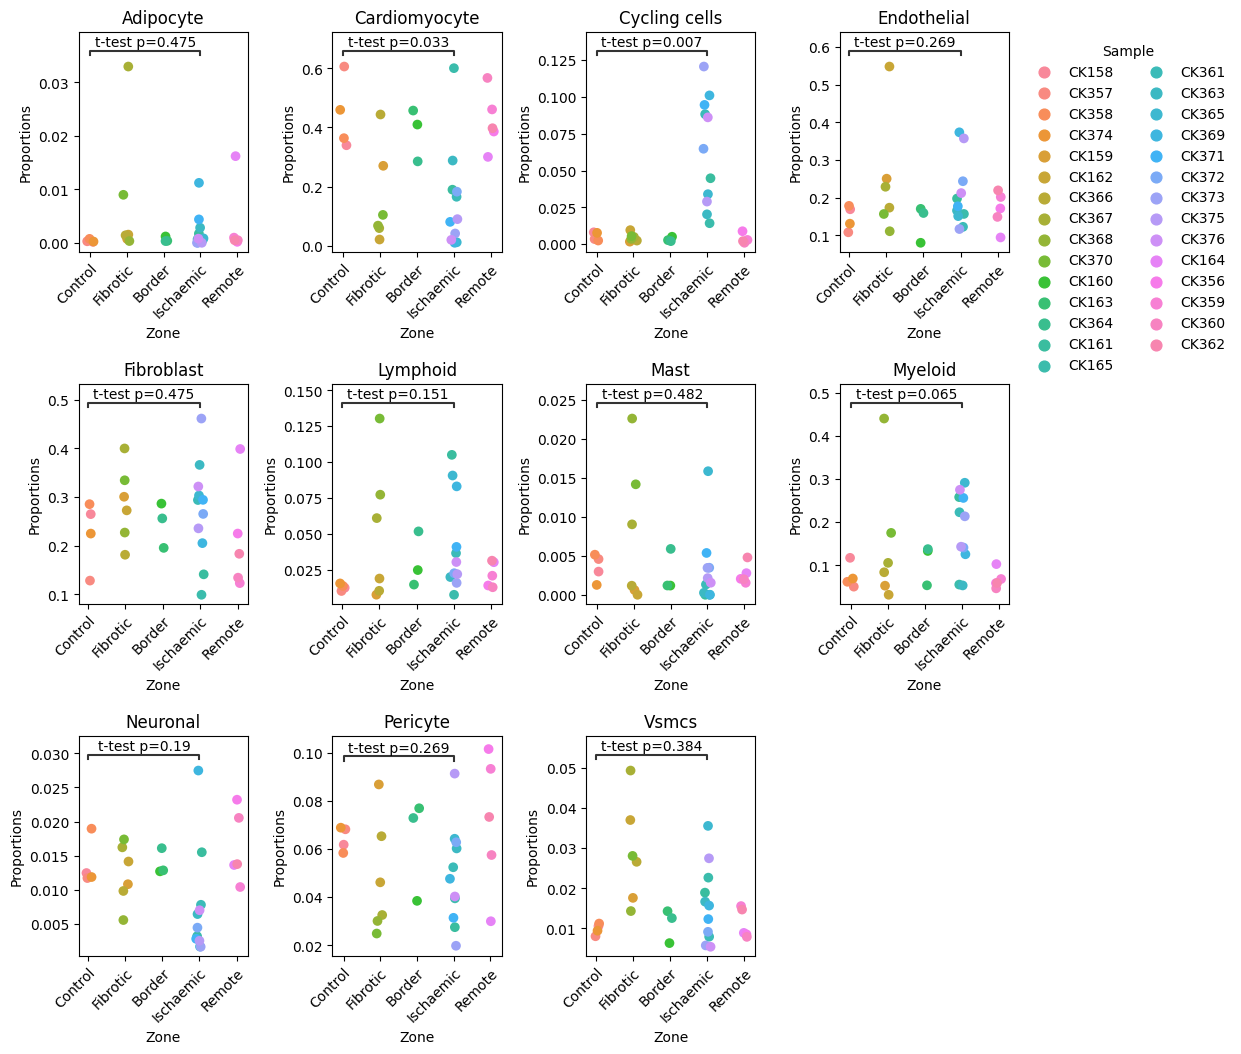

In [8]:
res_snrna.plot(n_columns=4, save=f"{FIG_PATH}/humanMI_rep_all.pdf")

### Without replicates

In [9]:
res_snrna_boot = scanpro.scanpro(human_MI, clusters_col='cell_type',
                                 conds_col='Zone', n_reps=8, conditions=['Control','Ischaemic'],
                                 transform='logit')
res_snrna_boot.results.to_csv("results/humanMI_scanpro_norep_logit.tsv", sep="\t")

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[WARNING] Consider setting transform='arcsin', as this produces more accurate results for simulated data.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 54.55 seconds


In [10]:
res_snrna_boot = scanpro.scanpro(human_MI, clusters_col='cell_type',
                                 conds_col='Zone', n_reps=8, conditions=['Control','Ischaemic'],
                                 transform='arcsin')

res_snrna_boot.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 53.41 seconds


,baseline_props,mean_props_Control,mean_props_Ischaemic,p_values
clusters,,,,
Adipocyte,0.002727,0.000197,0.001382,0.330257
Cardiomyocyte,0.336349,0.435557,0.139486,0.000021
Cycling cells,0.015537,0.004474,0.066946,0.000153
Endothelial,0.170411,0.145418,0.188093,0.153107
Fibroblast,0.246664,0.223161,0.296439,0.062627
Lymphoid,0.026403,0.011700,0.034682,0.093176
Mast,0.003749,0.002692,0.002833,0.595996
Myeloid,0.109919,0.074340,0.188807,0.001499
Neuronal,0.012701,0.012110,0.004204,0.186249


In [11]:
res_snrna_boot.results.to_csv("results/humanMI_scanpro_norep_arcsin.tsv", sep="\t")

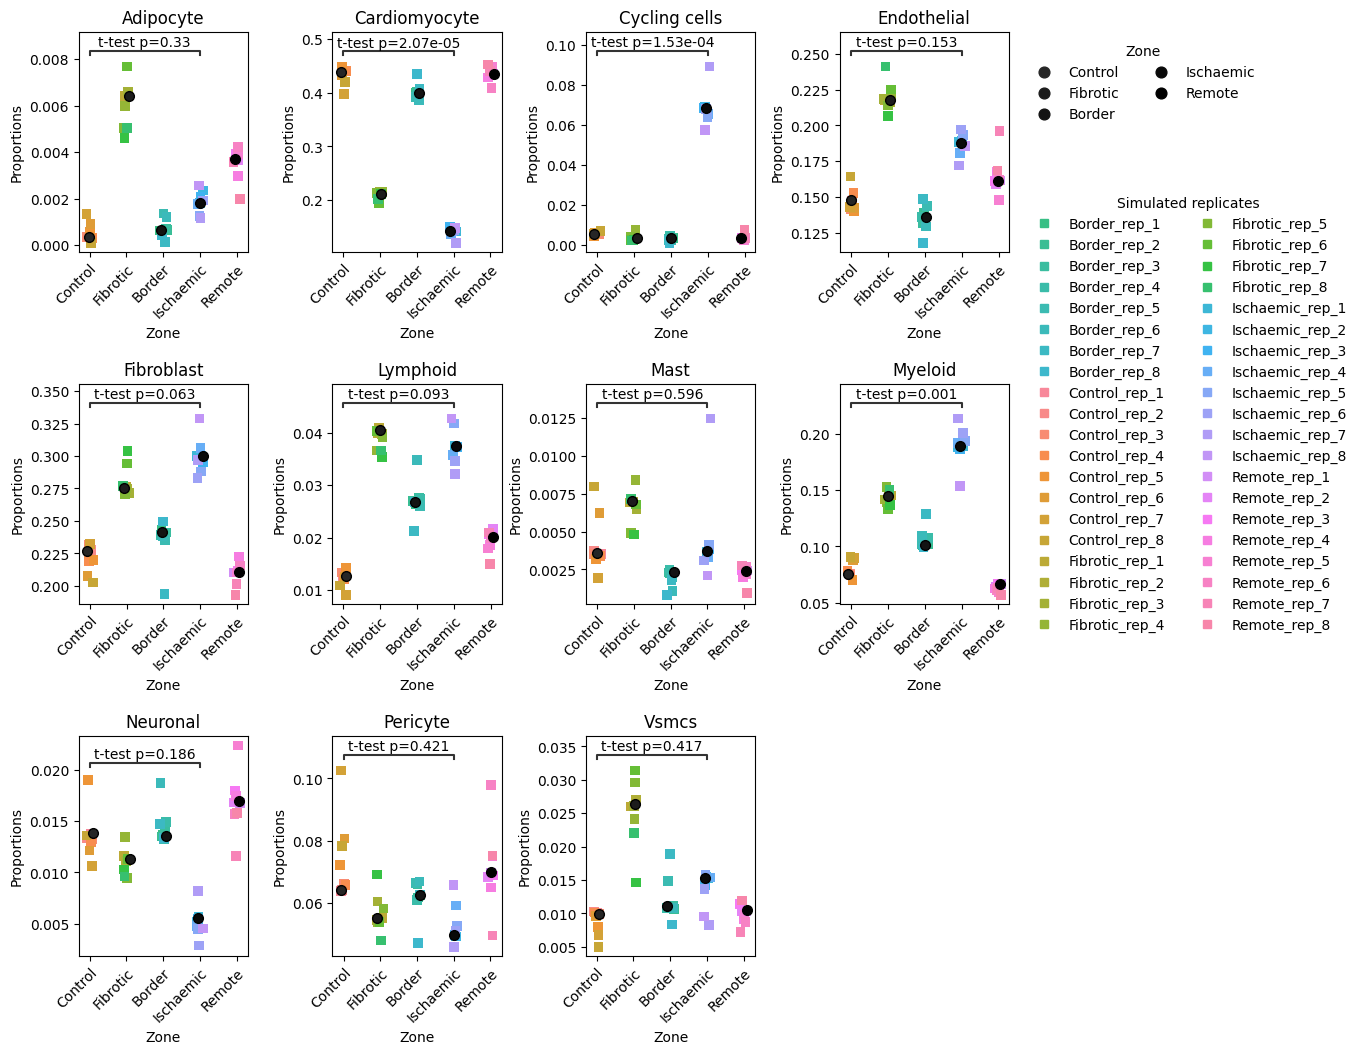

In [12]:
res_snrna_boot.plot(n_columns=4, save=f"{FIG_PATH}/humanMI_norep_all.pdf")

-------------------

# Run propeller

In [13]:
#Setup path to R for propeller
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

In [14]:
human_MI_sub = human_MI[human_MI["Zone"].isin(['Control','Ischaemic'])]

In [15]:
%%R -i human_MI_sub -o propeller_results_logit -o propeller_results_arcsin
library(speckle)

propeller_results_logit = propeller(clusters = human_MI_sub$cell_type, sample = human_MI_sub$Sample, 
                                    group = human_MI_sub$Zone, transform="logit")
propeller_results_arcsin = propeller(clusters = human_MI_sub$cell_type, sample = human_MI_sub$Sample, 
                                    group = human_MI_sub$Zone, transform="asin")


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)
Performing logit transformation of proportions
group variable has 2 levels, t-tests will be performed
Performing arcsin square root transformation of proportions
group variable has 2 levels, t-tests will be performed


In [16]:
propeller_results_logit.to_csv("results/humanMI_propeller_rep_logit.tsv", sep="\t")
propeller_results_arcsin.to_csv("results/humanMI_propeller_rep_arcsin.tsv", sep="\t")

In [17]:
propeller_results_arcsin

,BaselineProp.clusters,BaselineProp.Freq,PropMean.Control,PropMean.Ischaemic,PropRatio,Tstatistic,P.Value,FDR
Cycling cells,Cycling cells,0.033976,0.005429,0.063373,0.085660,-4.264094,0.000696,0.007661
Cardiomyocyte,Cardiomyocyte,0.304383,0.442471,0.152491,2.901614,3.161510,0.006532,0.035924
Myeloid,Myeloid,0.127041,0.074778,0.185137,0.403904,-2.641523,0.018643,0.068356
Lymphoid,Lymphoid,0.023929,0.012775,0.043002,0.297090,-2.070319,0.056313,0.154860
Neuronal,Neuronal,0.010100,0.013734,0.007297,1.882211,1.832013,0.086749,0.190848
Pericyte,Pericyte,0.057564,0.064351,0.048875,1.316650,1.506132,0.152668,0.273693
Endothelial,Endothelial,0.166060,0.146923,0.207000,0.709772,-1.427484,0.174168,0.273693
Vsmcs,Vsmcs,0.012293,0.009826,0.016152,0.608347,-1.118871,0.280682,0.385937
Adipocyte,Adipocyte,0.001024,0.000355,0.002084,0.170583,-0.841425,0.413239,0.467877
Fibroblast,Fibroblast,0.259978,0.225862,0.271549,0.831755,-0.802698,0.434832,0.467877


-------------

## Compare results with/without replicates

In [18]:
# get results with and without replicates
compare = {'Replicated': -np.log10(res_snrna.results.iloc[:,-1]),
           'Unreplicated': -np.log10(res_snrna_boot.results.iloc[:,-1])}

compare = pd.DataFrame(compare, index=res_snrna.results.index)

compare

,Replicated,Unreplicated
clusters,,
Adipocyte,0.323547,0.481148
Cardiomyocyte,1.475097,4.683396
Cycling cells,2.148783,3.815511
Endothelial,0.569780,0.815006
Fibroblast,0.323547,1.203241
Lymphoid,0.820274,1.030697
Mast,0.316794,0.224757
Myeloid,1.185541,2.824203
Neuronal,0.720946,0.729906


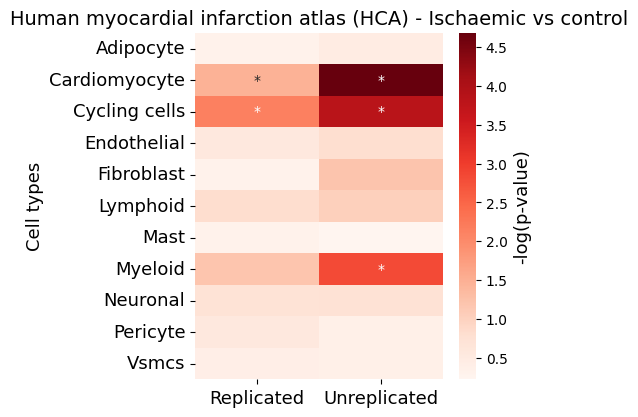

In [19]:
# annotation for heatmap
annot = {'Replicated': ['*' if value < 0.05 else '' for value in res_snrna.results.iloc[:,-1].to_list()],
         'Unreplicated': ['*' if value < 0.05 else '' for value in res_snrna_boot.results.iloc[:,-1].to_list()]}

fig, ax = plt.subplots(1, 1, figsize=(4, 4.5))

sns.heatmap(compare, annot=pd.DataFrame(annot), fmt='', cmap='Reds',
            ax=ax, cbar_kws={'label': '-log(p-value)'})

ax.set_title("Human myocardial infarction atlas (HCA) - Ischaemic vs control", fontsize=14)
ax.set_ylabel('Cell types', fontsize=13)

plt.tick_params(axis='both', which='major', labelsize=13)
ax.figure.axes[-1].yaxis.label.set_size(13)

plt.savefig(f'{FIG_PATH}/ischaemic_vs_ctrl.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [20]:
res_snrna_boot.props

cell_type,Adipocyte,Cardiomyocyte,Cycling cells,Endothelial,Fibroblast,Lymphoid,Mast,Myeloid,Neuronal,Pericyte,Vsmcs
Zone,,,,,,,,,,,
Border,0.000642,0.399924,0.003398,0.136391,0.241827,0.026840,0.002303,0.101510,0.013552,0.062514,0.011099
Control,0.000360,0.439479,0.005352,0.148213,0.226868,0.012649,0.003600,0.075727,0.013825,0.064062,0.009865
Fibrotic,0.006434,0.211660,0.003621,0.217927,0.275472,0.040555,0.007019,0.144560,0.011336,0.055094,0.026322
Ischaemic,0.001827,0.141133,0.068565,0.187627,0.299988,0.037560,0.003713,0.189048,0.005598,0.049713,0.015227
Remote,0.003699,0.434475,0.003248,0.161522,0.210619,0.020183,0.002403,0.066276,0.016916,0.070125,0.010533


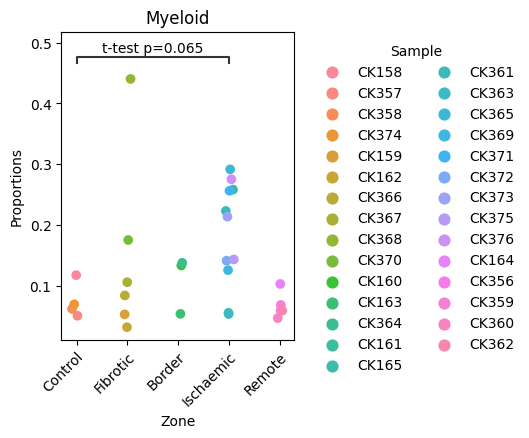

In [21]:
res_snrna.plot(clusters=["Myeloid"])

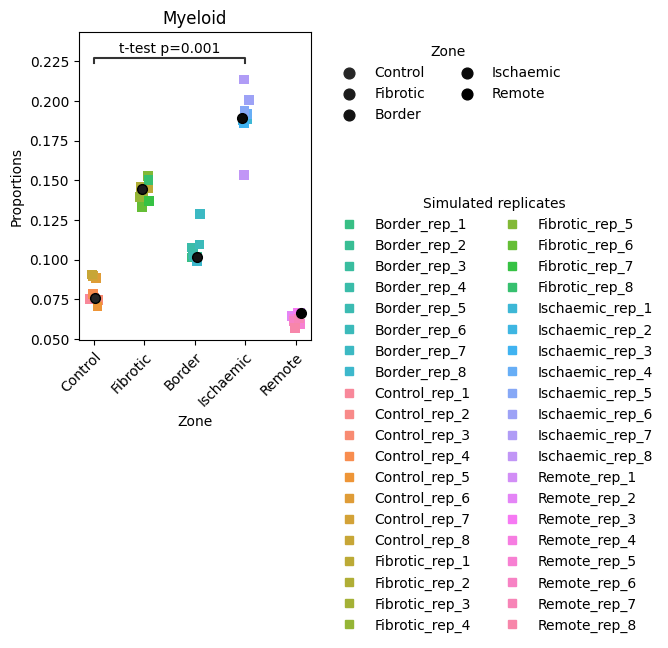

In [22]:
res_snrna_boot.plot(clusters=["Myeloid"])